<a href="https://colab.research.google.com/github/longhowlam/python_hobby_stuff/blob/master/GTST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goede Tijden Slechte Tijden 
Analysis of Dutch Soap series GTST

In [0]:
## Set up 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [28]:
!python -m spacy download nl

     |████████████████████████████████| 11.3MB 774kB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-840iwtze/wheels/48/98/b8/eb89625dcd24a84c4204c5d8e0089bf0df77cc085a6650dff9
Successfully built nl-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('nl_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/nl_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/nl
You can now load the model via spacy.load('nl')


In [0]:
import pandas as pd
import seaborn as sns

import spacy
nlp = spacy.load("nl")

## Import GTST summaries

In [30]:
gtst = pd.read_csv("/content/drive/My Drive/DataSets/GTST_Daily_data.csv")
gtst.sample(5)

,text_of_1month,datums,datums2
3823,Charlie kan Danny maar niet uit haar hoofd ze...,Dinsdag 29 maart 2011,29 3 2011
2517,Ludo probeert Stefano er met harde hand van t...,Maandag 31 mei 2004,31 5 2004
3669,Iemand wordt in kritieke toestand in het ziek...,Donderdag 24 juni 2010,24 6 2010
3462,Terwijl bij Danny een last van zijn schouders...,Donderdag 11 juni 2009,11 6 2009
3713,Onder grote belangstelling houdt Rutger een p...,Dinsdag 26 oktober 2010,26 10 2010


In [0]:
gtst = gtst.assign(
    datums2 = gtst.datums2.str.lstrip()
)
gtst = gtst.assign(
    datum = pd.to_datetime(gtst.datums2, format='%d %m %Y', errors = "coerce")
)

## NLP Stuff

### Count the number of PERSONS found in a text
Use SpaCy to find entiies, and in our case PERSONS (PER)

In [0]:
def count_persons(text):
  doc = nlp(text)
  return list(map(lambda x: x.label_, doc.ents)).count('PER')

In [59]:
count_persons(gtst.text_of_1month[300])

9

In [0]:
gtst = (
    gtst
    .assign(
        n_persons = gtst.text_of_1month.apply(count_persons)
    )
) 

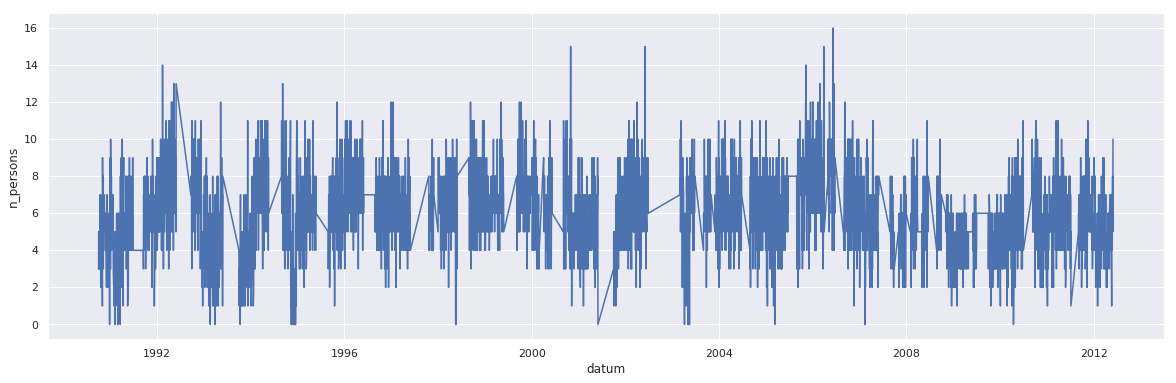

In [71]:
sns.set(rc={'figure.figsize':(20,6)})
sns.lineplot(x="datum", y = "n_persons", data = gtst)

In [0]:
!pip install calmap

In [0]:
events = pd.Series(gtst.n_persons.ravel(), index = gtst.datum.ravel())

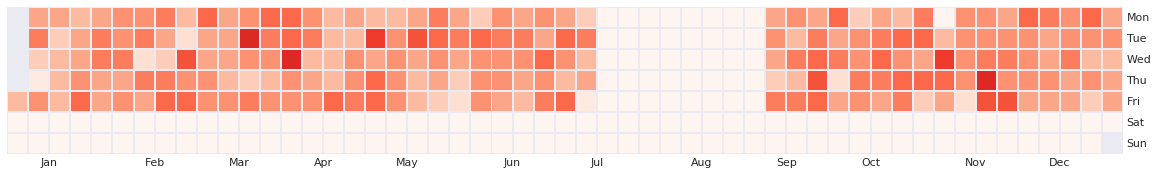

In [100]:
calmap.yearplot(events, year=2011)
